# Setup

In [1]:
from langserve_app.proxmox.docs import _proxmox_api_docs
from langserve_app.proxmox.base import ProxmoxAPIChain
from langchain.text_splitter import RecursiveJsonSplitter
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.retrievers import ContextualCompressionRetriever
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.vectorstores.surrealdb import SurrealDBStore
from langchain_huggingface import HuggingFaceEmbeddings
import nest_asyncio
import os
from dotenv import load_dotenv
from tqdm.autonotebook import tqdm, trange
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display
from langfuse.callback import CallbackHandler
from langchain_core.messages import BaseMessage
from typing import List, TypedDict
import yaml
import base64

C:\Users\oumay\AppData\Local\Temp\ipykernel_3636\2427049697.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
load_dotenv()

True

In [3]:
# Load the YAML file
with open(r'langserve_app\proxmox\dict.yaml', 'r') as file:
    proxmox_nodes = yaml.safe_load(file)

# Access the dictionary
"""for node in proxmox_nodes :
    print(f"Name: {node['name']}")
    print(f"Base URL: {node['base_url']}")
    decoded_token = base64.b64decode(os.getenv(node['token'])).decode('utf-8')
    print(f"Token: {decoded_token}\n")
    print(f"Token: {os.getenv(node['token'])}\n")"""


'for node in proxmox_nodes :\n    print(f"Name: {node[\'name\']}")\n    print(f"Base URL: {node[\'base_url\']}")\n    decoded_token = base64.b64decode(os.getenv(node[\'token\'])).decode(\'utf-8\')\n    print(f"Token: {decoded_token}\n")\n    print(f"Token: {os.getenv(node[\'token\'])}\n")'

In [4]:
surrealdb_url = os.getenv('SURREALDB_URL')
surrealdb_user = os.getenv('SURREALDB_USER')
surrealdb_password = os.getenv('SURREALDB_PWD')

In [5]:
splitter = RecursiveJsonSplitter(max_chunk_size=4000)
docs = splitter.create_documents(_proxmox_api_docs)

In [6]:
# Initialize the SentenceTransformerEmbeddings with trust_remote_code=True
ef = HuggingFaceEmbeddings(
    model_name="infgrad/stella_en_400M_v5",
    model_kwargs={
        "trust_remote_code": True,
    }
)

c:\Users\oumay\.vscode\agent-scripts-\venv\Lib\site-packages\xformers\ops\fmha\flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
c:\Users\oumay\.vscode\agent-scripts-\venv\Lib\site-packages\xformers\ops\fmha\flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Some weights of the model checkpoint at infgrad/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initi

In [7]:
nest_asyncio.apply()

# SurrealDB connection parameters
dburl = "ws://localhost:8000/rpc"
ns = "langchain"
db_name = "proxmox_api_docs"
collection = "proxmox_collection"
db_user = surrealdb_user
db_pass = surrealdb_password

# Initialize the SurrealDBStore with documents
db = SurrealDBStore(
    embedding_function=ef,
    dburl=dburl,
    ns=ns,
    db=db_name,
    collection=collection,
    db_user=db_user,
    db_pass=db_pass
)


# this is needed to initialize the underlying async library for SurrealDB
await db.initialize()

# delete collection from the vectorstore collection if it exists 
await db.adelete(collection = collection)

# add documents to the vectorstore
ids = await db.aadd_documents(docs)

retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 3})

# Initialize the cross-encoder model
#cross_encoder_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
cross_encoder_model = HuggingFaceCrossEncoder(model_name="cross-encoder/ms-marco-MiniLM-L-6-v2")
compressor = CrossEncoderReranker(model=cross_encoder_model, top_n=3)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

# Team approach

In [8]:
workers = [node["name"] for node in proxmox_nodes]

prompt = PromptTemplate(
    template=("""
    You are a supervisor tasked with routing a query to one of the following workers: {workers}. 
    Given the following user request, respond with the worker to act next. Each worker will perform a task 
    and respond with their results and status. The worker output will be returned to the user. 
    The options for workers are {workers}. Return 'end' if the request isn't related to any of the given workers.

    User request: {question}

    Respond in JSON format with a single key "next" which holds the worker name.

    next :
    """),
    input_variables=["question"],
    partial_variables={"workers": workers}
)

# Initialize the LLM
llm_sup = ChatOllama(model="phi3", temperature=0, format="json")
#llm_sup = ChatOllama(model="llama3.1", temperature=0, format="json")


# Combine prompt and LLM with JsonOutputParser
sup_chain = prompt | llm_sup | JsonOutputParser()


In [9]:
sup_chain.invoke({
    "question": "How many Vms on node ns31212248",
})

{'next': 'ns31212248'}

In [10]:
class ProxmoxTeamState(TypedDict):
    messages: List[BaseMessage]
    team_members: List[str]
    next: str

In [11]:
def supervisor(state: ProxmoxTeamState) -> ProxmoxTeamState:
    print(f"processing_request: Current state: {state}")
    question = state["messages"][0]
    print(question)
    result = sup_chain.invoke({"question": question})
    print(result)
    state["next"] = result["next"]
    state["team_members"] = [node["name"] for node in proxmox_nodes]
    return state

In [12]:
initial_state = {
            "messages": ["list Vms on node ns31212248"],
            "next": None,
            "team_members": []
        }
supervisor(initial_state)

processing_request: Current state: {'messages': ['list Vms on node ns31212248'], 'next': None, 'team_members': []}
list Vms on node ns31212248
{'next': 'ns31212248'}


{'messages': ['list Vms on node ns31212248'],
 'next': 'ns31212248',
 'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab']}

In [13]:
llm = ChatOllama(model="llama3.1", temperature=0, format="json")

In [14]:
"""from langchain_community.llms import Ollama
from typing import Dict, Any

# Initialize the LLM
#
llm_kwargs: Dict[str, Any] = {
    "model": "llama3:instruct",
    "temperature": 0,
    "num_ctx": 4096, 
    "format":"json"
}

llm = Ollama(**llm_kwargs)"""

'from langchain_community.llms import Ollama\nfrom typing import Dict, Any\n\n# Initialize the LLM\n#\nllm_kwargs: Dict[str, Any] = {\n    "model": "llama3:instruct",\n    "temperature": 0,\n    "num_ctx": 4096, \n    "format":"json"\n}\n\nllm = Ollama(**llm_kwargs)'

In [15]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [16]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the llm with the new model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0)

In [17]:
agents = {}

for node in proxmox_nodes:
    #print(node['base_url'])
    decoded_token=base64.b64decode(os.getenv(node['token'])).decode('utf-8')
    chain = ProxmoxAPIChain.from_llm_and_api_docs(
        llm,
        retriever=compression_retriever,
        headers={"Authorization": decoded_token},
        pve_token=decoded_token,
        verbose=True,
        limit_to_domains=[node["base_url"]],
        base_url=node["base_url"],
    )
    print(chain.base_url)
    agents[node["name"]] = chain

https://ns31418912.ip-54-38-37.eu:8006/
https://ns31212248.ip-51-178-74.eu:8006/
https://ns3132391.ip-51-75-130.eu:8006/


In [18]:
agents["ns31212248"].invoke(("list Vms on node 'ns31212248'"))



> Entering new ProxmoxAPIChain chain...


c:\Users\oumay\.vscode\agent-scripts-\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Retrieved Document 0: {"endpoint": "/api2/json/nodes/{node}/qemu", "method": "get", "summary": "List Virtual machines (VMs) on a Node", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where VMs are located", "schema": {"type": "string"}}]}
Retrieved Document 1: {"endpoint": "/api2/json/nodes/{node}/qemu/{vmid}/config", "method": "get", "summary": "Get Virtual machine/Vm Configuration (config file)", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where the VM is located", "schema": {"type": "string"}}, {"name": "vmid", "in": "path", "required": true, "description": "ID of the VM", "schema": {"type": "integer"}}, {"name": "current", "in": "query", "required": false, "description": "Get current values instead of pending values", "schema": {"type": "boolean"}}]}
Retrieved Document 2: {"endpoint": "/api2/json/nodes/{node}/lxc", "methods": "get", "summary": "List LXC Containers on a Node", "description": "List a

{'question': "list Vms on node 'ns31212248'",
 'output': "Here are the virtual machines running on node 'ns31212248':\n\n* KC2-WORKER-1\n* KC1-WORKER-1\n* cms-dev-env\n* KC2-MASTER-1\n* KC-Minio\n* KC2-WORKER-2\n* CLICKHOUSE-REPLICA-1\n* KC1-WORKER-3\n* ubuntu-tmp1\n* new-image-tmp-2\n* CMS-Gitlab-Runner\n* KC-Ansible-controller\n* IMX-Mongo-Test\n* KC-MASTER-2\n* network-lab\n* XCLOUD-DEVTOOLS\n* CMS-Master-Workstation\n* XCLOUD-ANSIBLE\n* CLICKHOUSE-REPLICA-3\n* ubuntu-tmp2\n* CLICKHOUSE-KEEPER-1\n* DefectDojo\n* cms-vm-k8s-production-01-worker-01\n* CLICKHOUSE-REPLICA-2\n* ML-OPS\n* vm-k8s-production-01-kubespray-01\n* KC1-WORKER-2\n* cms-vm-k8s-production-01-master-01 \n"}

In [19]:
def Worker_node(state: ProxmoxTeamState, node_name: str) -> ProxmoxTeamState:
    print(f"{state['next']} / {node_name}")
    question = state["messages"][0]
    result = agents[node_name].invoke(input=question)
    state["messages"].append(result)
    return state

In [20]:
state = {
    "next": "Proxmox-Node-HCM",
    "messages": ["How many Vms on node Proxmox-Node-HCM?"]
}

new_state = Worker_node(state, "Proxmox-Node-HCM")
print(new_state)  

Proxmox-Node-HCM / Proxmox-Node-HCM


> Entering new ProxmoxAPIChain chain...
Retrieved Document 0: {"endpoint": "/api2/json/nodes/{node}/qemu", "method": "get", "summary": "List Virtual machines (VMs) on a Node", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where VMs are located", "schema": {"type": "string"}}]}
Retrieved Document 1: {"endpoint": "/api2/json/nodes/{node}/qemu", "method": "post", "summary": "Create a Virtual machine (VM) ", "description": "Use this endpoint to create a new virtual machine on the specified node. This endpoint is used for initial creation and can be used for the allocation of resources such as memory, cores, and storage.", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where the VM will be created", "schema": {"type": "string"}}], "requestBody": {"required": true, "content": {"application/json": {"schema": {"type": "object", "properties": {"vmid": {"type": "integer", "des

In [21]:
def proxmox_router(state: ProxmoxTeamState) :
    next_worker = state["next"]
    print(f"proxmox_router: Current state: {state}")
    if next_worker in [node["name"] for node in proxmox_nodes]:
        return next_worker
    return "end"

In [22]:
state = {"next": "Proxmox-Node-HCM"}
result = proxmox_router(state)
print(result) 

proxmox_router: Current state: {'next': 'Proxmox-Node-HCM'}
Proxmox-Node-HCM


In [23]:
proxmox_graph = StateGraph(ProxmoxTeamState)

for node in proxmox_nodes:
    proxmox_graph.add_node(node["name"], lambda state, node_name=node["name"]: Worker_node(state, node_name))
    proxmox_graph.add_edge(node["name"], END)

proxmox_graph.add_node("supervisor", supervisor)

node_edges = {node["name"]: node["name"] for node in proxmox_nodes}

# Add the "end" key-value pair to the dictionary
node_edges["end"] = END

proxmox_graph.add_conditional_edges(
    "supervisor",
    proxmox_router,
    node_edges,
)

proxmox_graph.add_edge(START, "supervisor")
proxmox_agent = proxmox_graph.compile()

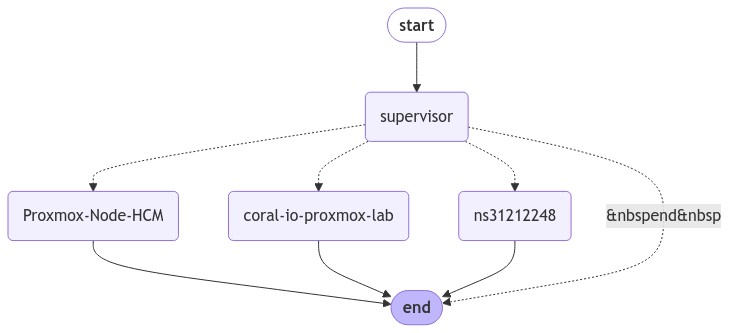

In [24]:
display(Image(proxmox_agent.get_graph().draw_mermaid_png()))

In [25]:
langfuse_handler = CallbackHandler(
    public_key=os.getenv('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.getenv('LANGFUSE_SECRET_KEY'),
    host=os.getenv('LANGFUSE_HOST'),
)

In [26]:
proxmox_agent.invoke({
            "messages": ["list Vms on node 'Proxmox-Node-HCM'"],
            "next": None,
            "team_members": []
        }, config={"callbacks": [langfuse_handler]})

processing_request: Current state: {'messages': ["list Vms on node 'Proxmox-Node-HCM'"], 'team_members': [], 'next': None}
list Vms on node 'Proxmox-Node-HCM'
{'next': 'Proxmox-Node-HCM'}
proxmox_router: Current state: {'messages': ["list Vms on node 'Proxmox-Node-HCM'"], 'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'], 'next': 'Proxmox-Node-HCM'}
Proxmox-Node-HCM / Proxmox-Node-HCM


> Entering new ProxmoxAPIChain chain...
Retrieved Document 0: {"endpoint": "/api2/json/nodes/{node}/qemu", "method": "get", "summary": "List Virtual machines (VMs) on a Node", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where VMs are located", "schema": {"type": "string"}}]}
Retrieved Document 1: {"endpoint": "/api2/json/nodes/{node}/qemu/{vmid}/config", "method": "get", "summary": "Get Virtual machine/Vm Configuration (config file)", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where the VM i

{'messages': ["list Vms on node 'Proxmox-Node-HCM'",
  {'question': "list Vms on node 'Proxmox-Node-HCM'",
   'output': 'The virtual machines running on the Proxmox-Node-HCM node are: MLFlow-Artifact-SFTP, test-vault01, NewRelic-GitLab, PgSQL-Primary, test-slave, PgSQL-IMX, PgSQL-IMX-Replicaset, MLFlow, primary-test, Ansible-controller, SurrealDB-IMX, Mongo-IMX, and test-vm. \n'}],
 'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'],
 'next': 'Proxmox-Node-HCM'}

In [27]:
proxmox_agent.invoke({
            "messages": ["list Vms on node ns31212248 "],
            "next": None,
            "team_members": []
        }, config={"callbacks": [langfuse_handler]})

processing_request: Current state: {'messages': ['list Vms on node ns31212248 '], 'team_members': [], 'next': None}
list Vms on node ns31212248 
{'next': 'ns31212248'}
proxmox_router: Current state: {'messages': ['list Vms on node ns31212248 '], 'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'], 'next': 'ns31212248'}
ns31212248 / ns31212248


> Entering new ProxmoxAPIChain chain...
Retrieved Document 0: {"endpoint": "/api2/json/nodes/{node}/qemu", "method": "get", "summary": "List Virtual machines (VMs) on a Node", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where VMs are located", "schema": {"type": "string"}}]}
Retrieved Document 1: {"endpoint": "/api2/json/nodes/{node}/qemu/{vmid}/config", "method": "get", "summary": "Get Virtual machine/Vm Configuration (config file)", "parameters": [{"name": "node", "in": "path", "required": true, "description": "Node ID where the VM is located", "schema": {"type": "string"}}, {"

{'messages': ['list Vms on node ns31212248 ',
  {'question': 'list Vms on node ns31212248 ',
   'output': 'Here are the virtual machines running on node ns31212248:\n\n* cms-vm-k8s-production-01-worker-01\n* ML-OPS\n* CLICKHOUSE-REPLICA-2\n* ubuntu-tmp2\n* CLICKHOUSE-KEEPER-1\n* DefectDojo\n* cms-vm-k8s-production-01-master-01\n* CLICKHOUSE-REPLICA-3\n* KC-MASTER-3\n* ubuntu-temp\n* KC1-MASTER-2\n* vm-k8s-production-01-kubespray-01\n* KC1-WORKER-2\n* KC-MASTER-2\n* IMX-Mongo-Test\n* XCLOUD-DEVTOOLS\n* CMS-Master-Workstation\n* XCLOUD-ANSIBLE\n* network-lab\n* new-image-tmp-2\n* KC-Ansible-controller\n* CMS-Gitlab-Runner\n* KC1-WORKER-3\n* ubuntu-tmp1\n* KC1-WORKER-1\n* KC2-WORKER-1\n* KC2-WORKER-2\n* CLICKHOUSE-REPLICA-1\n* cms-dev-env\n* KC-Minio\n* KC2-MASTER-1 \n'}],
 'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'],
 'next': 'ns31212248'}